In [147]:
import pandas as pd
import numpy as np
import sns as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

## Loading cleaned data

In [148]:
import pickle

with open('df_text_cleaned.pkl', 'rb') as file:
        df_text = pickle.load(file)

with open('df_num_cleaned.pkl', 'rb') as file:
        df_num = pickle.load(file)

with open('df_cat_cleaned.pkl', 'rb') as file:
        df_cat = pickle.load(file)

with open('df_target_cleaned.pkl', 'rb') as file:
        df_target = pickle.load(file)

## Concatenate the datasets

In [149]:
df = pd.concat([df_text, df_num, df_cat, df_target], axis = 1)

df_copy = df.copy()

In [150]:
df_copy.head(10)

,event_text,fatalities,injured,total_victims,age_of_shooter,latitude,longitude,year,month,day,prior_signs_mental_health_issues,weapons_obtained_legally,gender,type
0,maine bow alley restaurant shoot lewiston main...,18.0,13.0,21.0,40.0,38.323367,-90.874832,2023.0,10.0,25.0,yes,unknown,male,spree
1,jacksonville dollar general store shoot jackso...,3.0,0.0,3.0,21.0,38.323367,-90.874832,2023.0,8.0,26.0,yes,yes,male,mass
2,orange county baker bar shoot trabuco canyon c...,3.0,6.0,9.0,59.0,38.323367,-90.874832,2023.0,8.0,23.0,unknown,unknown,male,mass
3,philadelphia neighborhood shoot philadelphia p...,5.0,2.0,7.0,40.0,38.323367,-90.874832,2023.0,7.0,3.0,yes,yes,male,mass
4,new mexico neighborhood shoot farrington new m...,3.0,6.0,9.0,18.0,38.323367,-90.874832,2023.0,5.0,15.0,yes,yes,male,mass
5,texas outlet mall shooting allen texas maurice...,8.0,7.0,15.0,33.0,38.323367,-90.874832,2023.0,5.0,6.0,yes,yes,male,mass
6,louisville bank shooting louisville kentucky s...,5.0,8.0,13.0,25.0,38.323367,-90.874832,2023.0,4.0,10.0,yes,yes,male,mass
7,nashville christian school shoot nashville ten...,6.0,6.0,12.0,28.0,38.323367,-90.874832,2023.0,3.0,27.0,unknown,yes,female,mass
8,michigan state university shoot east landing m...,3.0,5.0,8.0,43.0,38.323367,-90.874832,2023.0,2.0,13.0,unknown,yes,male,mass
9,half moon bay spree shoot half moon bay califo...,7.0,1.0,8.0,67.0,38.323367,-90.874832,2023.0,1.0,23.0,unknown,unknown,male,spree


In [151]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   event_text                        148 non-null    object 
 1   fatalities                        148 non-null    float64
 2   injured                           148 non-null    float64
 3   total_victims                     148 non-null    float64
 4   age_of_shooter                    148 non-null    float64
 5   latitude                          148 non-null    float64
 6   longitude                         148 non-null    float64
 7   year                              148 non-null    float64
 8   month                             148 non-null    float64
 9   day                               148 non-null    float64
 10  prior_signs_mental_health_issues  148 non-null    object 
 11  weapons_obtained_legally          148 non-null    object 
 12  gender  

## **Train - Test Split of Dataset**

In [152]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_copy.drop('type', axis = 1),
                                                    df_copy['type'],
                                                    train_size=0.7,
                                                    random_state=42)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(103, 13)
(103,)
(45, 13)
(45,)


In [153]:
# Creating the list of numeric and categorical columns

float_columns = [col for col in df_copy.columns if df_copy[col].dtype == 'float']  # List of column names with float features
cat_columns = [col for col in df_copy.columns if df_copy[col].dtype == 'object' and col not in ['type', 'event_text']]  # List of column names with binary features

## Preprocessing Data

### Target

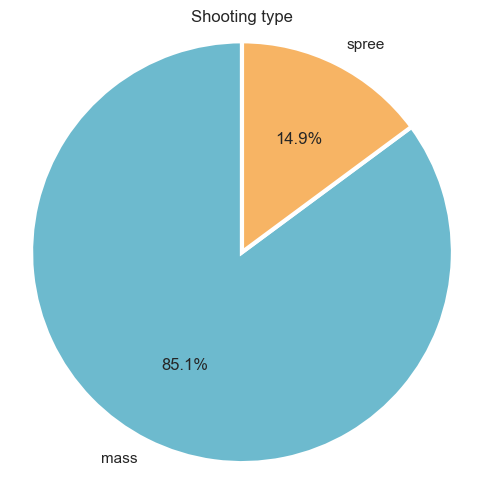

In [154]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Create data
shoots_counts = df_copy['type'].value_counts()
labels = shoots_counts.index
sizes = shoots_counts.values

# --------------------------------------------------
# Pie Plot
fig, ax = plt.subplots(figsize = (5,5))

pcts = ax.pie(sizes,
              labels = labels,
              autopct = '%1.1f%%',
              colors = ['#6dbace', '#f7b464'],
              wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},    # <------------- Style the wedges
              startangle = 90)

# Add a title
plt.title('Shooting type')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.tight_layout()        # <------------- Adjust subplot spacing

# Display the chart
plt.show()

The target is highly imbalanced. Imbalanced data together with the small sized sample will create overfitting.  I will apply resampling techniques to balance the data (maybe oversampling?).

**Target Encoding**

In [155]:
# Encode the target

# Instantiate the LabelEncoder
encoder = LabelEncoder()

# Encode the target variable in train dataset
Y_train_encoded = encoder.fit_transform(Y_train)

# Encode the target variable in test dataset
Y_test_encoded = encoder.transform(Y_test)

In [156]:
# Show encoding map for Y_train and Y_test
mappings = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

mappings

{'mass': 0, 'spree': 1}

<div style="color:white; background-color:  #5f87a8; padding: 10px;">
<center>
<b>
# VIA 1 (SIMPLE STEPS BUT LONGER CODE) </b>
</center>
</div>

### Text Data

- **TF-IDF Features**

In [157]:
X_train_tfidf = pd.DataFrame()
X_test_tfidf = pd.DataFrame()

for i in [1,2,3]:
    text_transformer = TfidfVectorizer(max_features = 10,
                                       norm = 'l2',
                                       stop_words = 'english',
                                       use_idf = True,
                                       ngram_range = (i,i))     # It specifies that unigrams (individual words) (1,1), bigrams (sequences of two adjacent words) (2,2), and trigrams (sequences of three adjacent words) should be considered. Each of these  unigrams, bigrams and trigrams becomes a feature, and the tf-idf values are calculated for these features in each document (text). The resulting feature matrix represents the importance of each trigram in the context of each document.

    train_tfidf = text_transformer.fit_transform(X_train['event_text']).toarray()
    X = pd.DataFrame(train_tfidf,
                     index = X_train.index,
                     columns = ['tfidf_' + n for n in text_transformer.get_feature_names_out()]
                     )
    # X_train_tfidf = pd.concat([X_train_tfidf.reset_index(drop = True), X.reset_index(drop = True)], axis = 1)
    X_train_tfidf = pd.concat([X_train_tfidf, X], axis = 1)

    test_tfidf = text_transformer.transform(X_test['event_text']).toarray()
    X = pd.DataFrame(test_tfidf,
                     index = X_test.index,
                     columns = ['tfidf_' + n for n in text_transformer.get_feature_names_out()]
                     )
    # X_test_tfidf = pd.concat([X_test_tfidf.reset_index(drop = True), X.reset_index(drop = True)], axis = 1)
    X_test_tfidf = pd.concat([X_test_tfidf, X], axis = 1)
# ----------------------------------------------------------------
print('TF-IDF cv_train:', X_train_tfidf.shape)
print('TF-IDf cv_test:', X_test_tfidf.shape)

# ---------------------------------------------------------------
display(X_train_tfidf.head())
display(X_test_tfidf.head())

TF-IDF cv_train: (103, 30)
TF-IDf cv_test: (45, 30)


,tfidf_handful,tfidf_kill,tfidf_open,tfidf_police,tfidf_rifle,tfidf_school,tfidf_semiautomatic,tfidf_shoot,tfidf_white,tfidf_workplace,...,tfidf_handful workplace white,tfidf_law enforcement officer,tfidf_rifle assault shotgun,tfidf_rifle semiautomatic handful,tfidf_self inflict gunshot,tfidf_semiautomatic handful rifle,tfidf_semiautomatic handful workplace,tfidf_semiautomatic handgun rifle,tfidf_semiautomatic rifle semiautomatic,tfidf_shotgun workplace white
93,0.000000,0.511834,0.468285,0.000000,0.000000,0.000000,0.388706,0.412952,0.443974,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141,0.258530,0.264471,0.000000,0.252810,0.283800,0.761751,0.200849,0.213377,0.229406,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
108,0.249619,0.255354,0.000000,0.000000,0.274017,0.735493,0.193926,0.412044,0.221499,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.000000,0.000000,0.459260,0.000000,0.538656,0.000000,0.381214,0.404993,0.435416,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
73,0.000000,0.000000,0.246268,0.257302,0.288842,0.775286,0.000000,0.434337,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,tfidf_handful,tfidf_kill,tfidf_open,tfidf_police,tfidf_rifle,tfidf_school,tfidf_semiautomatic,tfidf_shoot,tfidf_white,tfidf_workplace,...,tfidf_handful workplace white,tfidf_law enforcement officer,tfidf_rifle assault shotgun,tfidf_rifle semiautomatic handful,tfidf_self inflict gunshot,tfidf_semiautomatic handful rifle,tfidf_semiautomatic handful workplace,tfidf_semiautomatic handgun rifle,tfidf_semiautomatic rifle semiautomatic,tfidf_shotgun workplace white
125,0.000000,0.000000,0.346942,0.362487,0.406921,0.00000,0.000000,0.611893,0.000000,0.456330,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0
51,0.000000,0.209438,0.000000,0.000000,0.224744,0.90486,0.159055,0.168976,0.181670,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0
139,0.000000,0.761258,0.348243,0.363847,0.408447,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0
19,0.238252,0.487453,0.000000,0.232981,0.523079,0.00000,0.370190,0.393281,0.000000,0.293297,...,0.0,0.0,0.0,0.60192,0.0,0.0,0.52477,0.0,0.60192,0.0
104,0.000000,0.000000,0.552621,0.000000,0.648157,0.00000,0.000000,0.000000,0.523931,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0


### Numerical and Categorical Data

In [158]:
# Define the transformations for each data type
float_transformer = StandardScaler()

cat_transformer = OneHotEncoder(handle_unknown='ignore')

In [159]:
# Combine the transformers and apply them to training and test data
preprocessor = ColumnTransformer(transformers=[('float', float_transformer, float_columns),
                                               ('cat', cat_transformer, cat_columns)
                                              ])

# Train dataset
X_traintr = pd.DataFrame(preprocessor.fit_transform(X_train[float_columns + cat_columns]),
                         index = X_train.index)

# Get feature names for the transformed data
feature_names = float_columns + list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_columns))
X_traintr.columns = feature_names            # Assign feature names to the DataFrame

# Test dataset
X_testtr = pd.DataFrame(preprocessor.transform(X_test[float_columns + cat_columns]),
                        index = X_test.index)
X_testtr.columns = feature_names

In [160]:
X_testtr

,fatalities,injured,total_victims,age_of_shooter,latitude,longitude,year,month,day,prior_signs_mental_health_issues_no,prior_signs_mental_health_issues_unknown,prior_signs_mental_health_issues_yes,weapons_obtained_legally_no,weapons_obtained_legally_unknown,weapons_obtained_legally_yes,gender_female,gender_male,gender_male_and_female
125,-0.388220,-0.200932,-0.229500,0.655713,-0.753566,-1.320889,-1.410009,1.679418,0.225670,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
51,1.216596,0.078241,0.226060,-1.100605,-2.245460,1.024154,0.656285,-1.302997,-0.225670,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
139,0.280453,-0.163709,-0.111392,0.735545,-1.442518,0.937665,-2.098774,-0.110031,0.225670,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
19,-0.521955,-0.238155,-0.280118,0.975043,0.150701,0.362431,1.049864,-0.110031,-1.692527,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
104,0.146719,-0.163709,-0.128264,-1.100605,0.737323,0.038433,-0.426060,1.679418,-1.241186,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
12,-0.388220,0.227132,0.158569,-0.861107,0.150701,0.362431,1.049864,1.381176,0.338505,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
76,-0.655689,-0.219543,-0.280118,-0.461944,1.323159,0.512635,0.361100,-0.110031,-0.564176,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
31,-0.521955,-0.182320,-0.229500,-0.022865,0.626003,1.410126,0.754680,1.679418,-0.677011,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
81,0.547923,-0.089263,-0.010156,0.096884,0.260677,1.228498,0.164310,0.784693,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
9,-0.120751,-0.219543,-0.212627,2.731361,0.150701,0.362431,1.148259,-1.601238,0.789846,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Combine the preprocessed data into a single dataframe

In [161]:
X_train_prep = pd.concat([X_train_tfidf, X_traintr], axis = 1)

X_test_prep = pd.concat([X_test_tfidf, X_testtr], axis = 1)

In [162]:
X_test_prep

,tfidf_handful,tfidf_kill,tfidf_open,tfidf_police,tfidf_rifle,tfidf_school,tfidf_semiautomatic,tfidf_shoot,tfidf_white,tfidf_workplace,...,day,prior_signs_mental_health_issues_no,prior_signs_mental_health_issues_unknown,prior_signs_mental_health_issues_yes,weapons_obtained_legally_no,weapons_obtained_legally_unknown,weapons_obtained_legally_yes,gender_female,gender_male,gender_male_and_female
125,0.000000,0.000000,0.346942,0.362487,0.406921,0.000000,0.000000,0.611893,0.000000,0.456330,...,0.225670,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
51,0.000000,0.209438,0.000000,0.000000,0.224744,0.904860,0.159055,0.168976,0.181670,0.000000,...,-0.225670,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
139,0.000000,0.761258,0.348243,0.363847,0.408447,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.225670,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
19,0.238252,0.487453,0.000000,0.232981,0.523079,0.000000,0.370190,0.393281,0.000000,0.293297,...,-1.692527,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
104,0.000000,0.000000,0.552621,0.000000,0.648157,0.000000,0.000000,0.000000,0.523931,0.000000,...,-1.241186,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
12,0.355333,0.000000,0.332570,0.347471,0.390064,0.000000,0.552108,0.293273,0.315304,0.000000,...,0.338505,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
76,0.000000,0.470490,0.000000,0.449746,0.000000,0.000000,0.000000,0.759189,0.000000,0.000000,...,-0.564176,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
31,0.000000,0.561147,0.256701,0.536406,0.301079,0.000000,0.426156,0.000000,0.243374,0.000000,...,-0.677011,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
81,0.324919,0.332384,0.304104,0.635459,0.000000,0.000000,0.000000,0.536341,0.000000,0.000000,...,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
9,0.458521,0.000000,0.000000,0.448376,0.000000,0.000000,0.356219,0.378439,0.000000,0.564455,...,0.789846,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Baseline Models

So far:
- *Random Forest Classifier*
- *Logistic Regression*
- *Support Vector Machine*

### Random Forest Classifier

In [163]:
# Instantiate the model
model_rf = RandomForestClassifier()

# Fit the model to the data
model_rf.fit(X_train_prep, Y_train_encoded)

print('\n ---------------------------------------------------------------------')
print("Training accuracy for {}: {}".format('RFClass', np.mean(model_rf.predict(X_train_prep.values) == Y_train_encoded)*100))
print ('Test accuracy for {}: {}'.format('RFClass', np.mean(model_rf.predict(X_test_prep.values) == Y_test_encoded)*100))


 ---------------------------------------------------------------------
Training accuracy for RFClass: 100.0
Test accuracy for RFClass: 82.22222222222221


C:\Users\luthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\luthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,Importance
tfidf_shoot,0.068730
latitude,0.060714
tfidf_kill,0.059799
tfidf_open,0.054566
year,0.054179
day,0.051274
month,0.047203
injured,0.045909
tfidf_semiautomatic,0.045342
tfidf_handful,0.043423


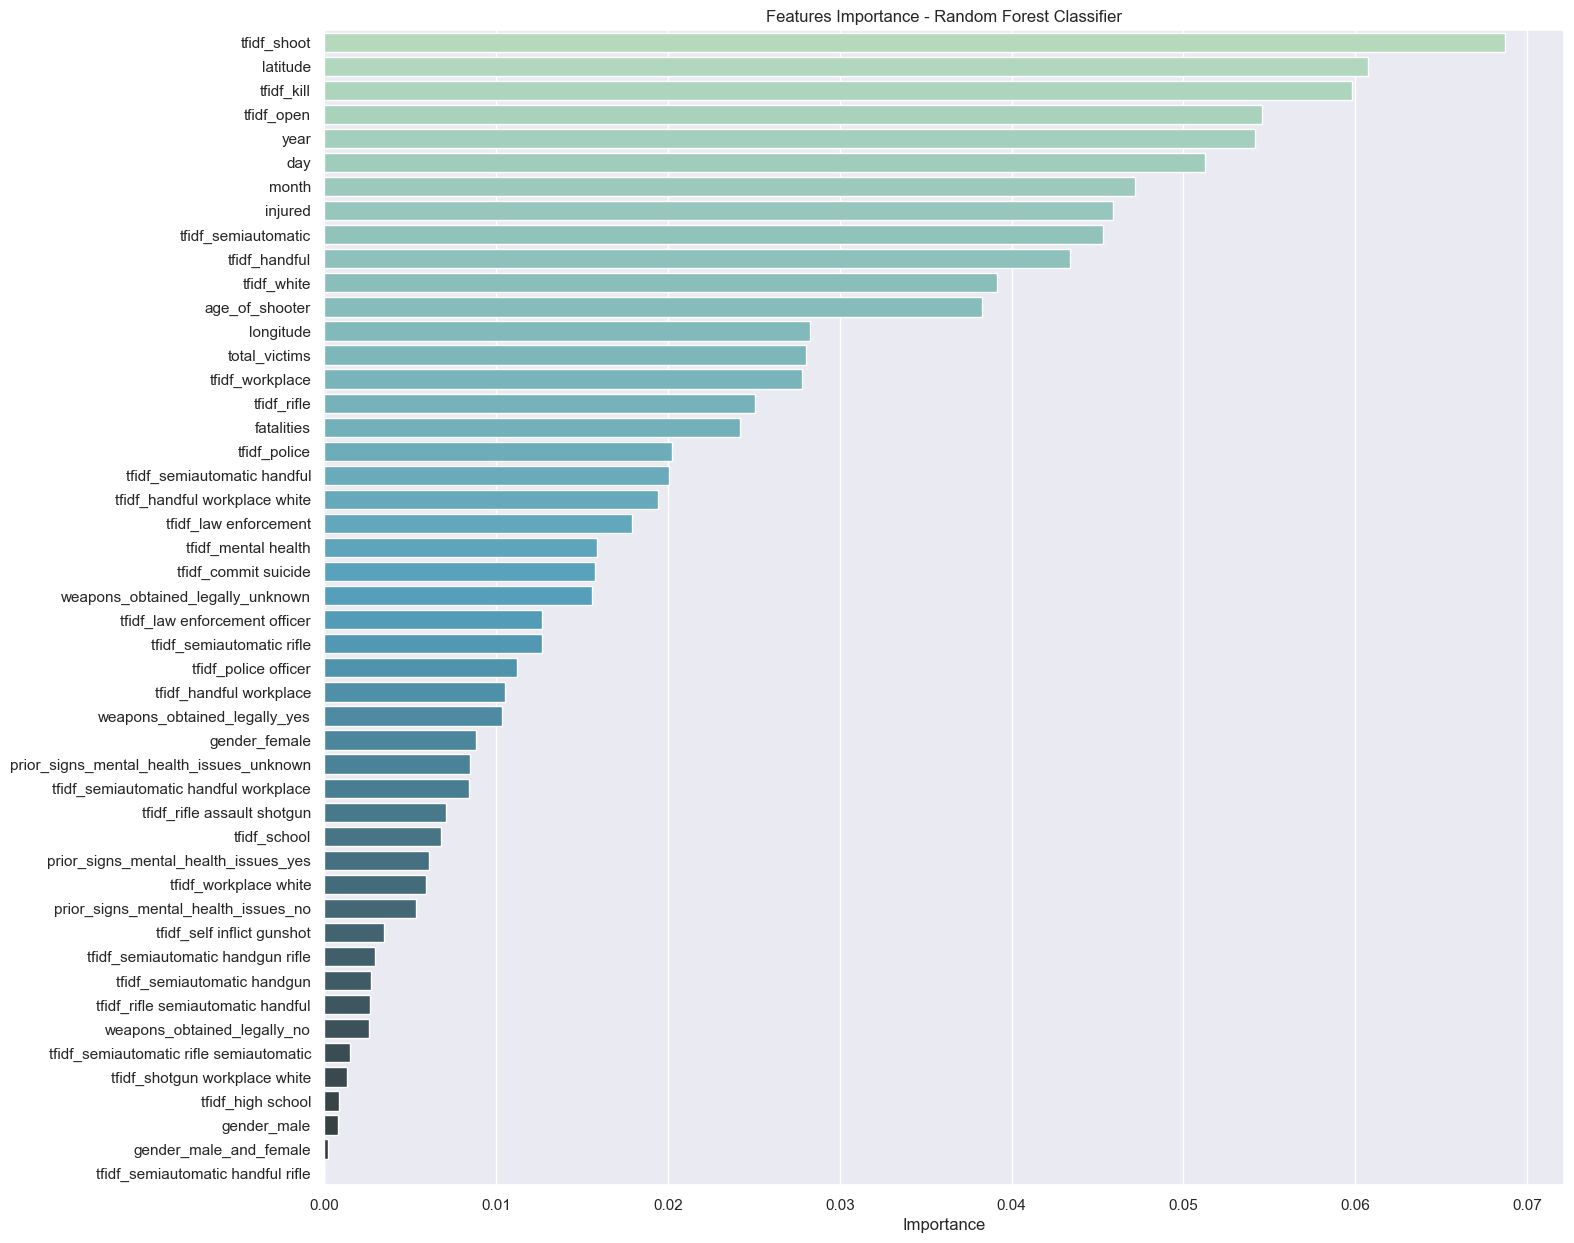

In [164]:
# Get the feature importance according to Random Forest
df_rfimportance = pd.DataFrame(model_rf.feature_importances_,
                               index = list(X_train_prep.columns),
                               columns = ['Importance'])

# Sort the features according to their importance in descending order
df_rfimportance_sorted = df_rfimportance.sort_values(by = 'Importance',
                                                     ascending = False)

display(df_rfimportance_sorted)

# -----------------------------------------------------------
# Plot features scores

plt.figure(figsize = (16,15))

sns.barplot(x = df_rfimportance_sorted['Importance'],
            y = df_rfimportance_sorted.index,
            orient = 'h',
            palette = 'GnBu_d')

plt.title("Features Importance - Random Forest Classifier")
plt.show()

### Logistic Regression

In [165]:
from sklearn.linear_model import LogisticRegression

# Instantiate the model
model_logreg = LogisticRegression()

# Fit the model to the data
model_logreg.fit(X_train_prep, Y_train_encoded)

print('\n ---------------------------------------------------------------------')
print("Training accuracy for {}: {}".format('LogReg', np.mean(model_logreg.predict(X_train_prep.values) == Y_train_encoded)*100))
print ('Test accuracy for {}: {}'.format('LogReg', np.mean(model_logreg.predict(X_test_prep.values) == Y_test_encoded)*100))


 ---------------------------------------------------------------------
Training accuracy for LogReg: 87.37864077669903
Test accuracy for LogReg: 80.0


C:\Users\luthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\luthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Support Vector Machine

In [166]:
from sklearn.svm import SVC

# Instantiate the model
model_svc = SVC(kernel = 'rbf',
                probability = True)

# Fit the model to the data
model_svc.fit(X_train_prep, Y_train_encoded)

print('\n ---------------------------------------------------------------------')
print("Training accuracy for {}: {}".format('SVC', np.mean(model_svc.predict(X_train_prep.values) == Y_train_encoded)*100))
print ('Test accuracy for {}: {}'.format('SVC', np.mean(model_svc.predict(X_test_prep.values) == Y_test_encoded)*100))


 ---------------------------------------------------------------------
Training accuracy for SVC: 86.40776699029125
Test accuracy for SVC: 82.22222222222221


C:\Users\luthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\luthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


<div style="color:white; background-color:  #5f87a8; padding: 10px;">
<center>
<b> VIA 2 (USING FUNCTIONTRANSFORMER AND FEATUREUNION) </b>
</center>
</div>

**FunctionTransformer**:
In scikit-learn is a useful tool for applying a custom function to your data. It allows you to use a function that transforms one or more columns in your dataset and use it as a transformer in a scikit-learn pipeline.

**FeatureUnion**:
In scikit-learn FeatureUnion is a transformer that concatenates the output of multiple transformer objects into a composite feature space. This can be useful when you have different types of features that need separate preprocessing steps.

## Baseline Models

In [167]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier


In [168]:
def baseline_models(X_train, X_test, Y_train_encoded, Y_test_encoded):
    '''
    Function to apply the classifier models to the US Mass Shootings dataset
    :param X_train: Train data containing a text column, 8 numerical columns and 3 categorical columns
    :param X_test:  test data with the same structure than training data
    :param Y_train_encoded: Labels in train data
    :param Y_test_encoded: Labels in test data
    :return: Dataframe with the accuracy of each baseline model
    '''

    # Make a dictionary to keep model scores
    model_scores = {}

    # 1. Instantiate the models to be applied: ---------------------------------------------------------
    models = {'KNN': KNeighborsClassifier(),
              'LogReg': LogisticRegression(),
              'SVM': SVC(kernel = 'rbf',
                         probability = True),
              'RFClass': RandomForestClassifier(random_state = 42)}

    # 2. Define the custom functions to extract features using FunctionTransformer(): -------------------
    #    (These functions extract specific types of data from the input dataframe. They are used to separate text, numeric, and categorical data)

    get_text_data = FunctionTransformer(lambda x: x['event_text'], validate=False)
    get_numeric_data = FunctionTransformer(lambda x: x[float_columns], validate=False)
    get_category_data = FunctionTransformer(lambda x: x[cat_columns], validate=False)

    # 3. Create the transformers: ----------------------------------------------------------------------

    num_transformer = Pipeline([('selector', get_numeric_data),             # Applies the numeric feature selector and scales the numeric data
                                ('scaler', StandardScaler())
                               ])

    cat_transformer = Pipeline([('selector', get_category_data),            # Applies the categorical feature selector and performs one-hot encoding
                                ('ohe', OneHotEncoder(handle_unknown='ignore'))
                               ])

    text_transformer = Pipeline([('selector', get_text_data),               # Applies the text feature selector and vectorizes text data
                                 ('tfidf_vectorizer', TfidfVectorizer())
                            ])

    # 4. Create FeatureUnion ----------------------------------------------------------------------------
    #    (FeatureUnion is used to combine the results of the three transformers. It concatenates the numeric, categorical, and text features)
    preprocessor = FeatureUnion(transformer_list = [('numerical', num_transformer),
                                                    ('cat', cat_transformer),
                                                    ('text', text_transformer)
                                                   ])

    # Loop through models
    for name, model in models.items():

        # 5. Create the Pipeline with the Baseline Model ----------------------------------------------------

        pipe = Pipeline([('preprocessor', preprocessor),
                         (name, model)
                        ])

        # 6. Fit and apply the pipeline to Train and Test datasets ------------------------------------------
        pipe.fit(X_train,Y_train_encoded)

        # Evaluate the model and append its score to model_scores
        model_scores[name] = [pipe.score(X_train, Y_train_encoded), pipe.score(X_test, Y_test_encoded)]
        df_models = pd.DataFrame(model_scores, index=["X_train", 'X_test'])

        print('\n ---------------------------------------------------------------------')
        print("Training accuracy for {}: {}".format(name, np.mean(pipe.predict(X_train) == Y_train_encoded)*100))
        print ('Test accuracy for {}: {}'.format(name, np.mean(pipe.predict(X_test) == Y_test_encoded)*100))

    display(df_models)

    return df_models

In [169]:
df_models = baseline_models(X_train, X_test, Y_train_encoded, Y_test_encoded)


 ---------------------------------------------------------------------
Training accuracy for KNN: 87.37864077669903
Test accuracy for KNN: 82.22222222222221

 ---------------------------------------------------------------------
Training accuracy for LogReg: 87.37864077669903
Test accuracy for LogReg: 82.22222222222221

 ---------------------------------------------------------------------
Training accuracy for SVM: 86.40776699029125
Test accuracy for SVM: 82.22222222222221

 ---------------------------------------------------------------------
Training accuracy for RFClass: 100.0
Test accuracy for RFClass: 82.22222222222221


,KNN,LogReg,SVM,RFClass
X_train,0.873786,0.873786,0.864078,1.000000
X_test,0.822222,0.822222,0.822222,0.822222


## Hyperparameter tuning

- *Random Forest Classifier*

In [170]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [171]:
def model_GSearch(X_train, X_test, Y_train_encoded, Y_test_encoded):

    # 1. Create the pipeline with the model ----------------------------------------------------------
    get_text_data = FunctionTransformer(lambda x: x['event_text'], validate=False)
    get_numeric_data = FunctionTransformer(lambda x: x[float_columns], validate=False)
    get_category_data = FunctionTransformer(lambda x: x[cat_columns], validate=False)

    num_transformer = Pipeline([('selector', get_numeric_data),             # Applies the numeric feature selector and scales the numeric data
                                ('scaler', StandardScaler())
                               ])

    cat_transformer = Pipeline([('selector', get_category_data),            # Applies the categorical feature selector and performs one-hot encoding
                                ('ohe', OneHotEncoder(handle_unknown='ignore'))
                               ])

    text_transformer = Pipeline([('selector', get_text_data),               # Applies the text feature selector and vectorizes text data
                                 ('tfidf_vectorizer', TfidfVectorizer())
                            ])

    preprocessor = FeatureUnion(transformer_list = [('numerical', num_transformer),
                                                    ('cat', cat_transformer),
                                                    ('text', text_transformer)
                                                   ])

    pipe = Pipeline([('preprocessor', preprocessor),
                     ('RFClass', RandomForestClassifier())
                    ])

    # 2. Grid Search Parameters for RandomForest -------------------------------------------------------
    search_space_grid = {'RFClass__n_estimators': np.linspace(1, 100, 10, dtype=int),
                         'RFClass__min_samples_split': [3, 10],
                         'RFClass__min_samples_leaf': [3],
                         # 'RFClass__max_features': [7],
                         'RFClass__max_depth': [None],
                         'RFClass__criterion': ['gini'],
                         'RFClass__bootstrap': [False]}

    # 3. Configurate the Grid Search -------------------------------------------------------------------
    kfold = StratifiedKFold(n_splits = 3)       # Used to perform stratified k-fold cross-validation
    scoring = {'Accurary': 'accuracy',
               'F1': 'f1_macro'}
    refit = 'F1'                               # This means that after the grid search, the model with the best F1 score will be refitted on the entire dataset.

    # 4. Perform GridSearch ----------------------------------------------------------------------------
    GS_model = GridSearchCV(pipe,
                            param_grid = search_space_grid,
                            cv = kfold,                    # as cross-validation strategy I use stratified k-fold in this case
                            scoring = scoring,
                            refit = refit,                 # the metric to use for choosing the best estimator
                            n_jobs = -1,
                            return_train_score = True,     # whether to include training scores in the result
                            verbose = 1)

    GS_model.fit(X_train,Y_train_encoded)

    GS_model_best = GS_model.best_estimator_

    print(GS_model_best)

    print('RandomForest (with Grid Search) \n -------------------------------------------------------------')
    print("Training accuracy for {}: {}".format('RandomForest', np.mean(GS_model.predict(X_train) == Y_train_encoded)*100))
    print ('Test accuracy for {}: {}'.format('RandomForest', np.mean(GS_model.predict(X_test) == Y_test_encoded)*100))

In [172]:
model_GSearch(X_train, X_test, Y_train_encoded, Y_test_encoded)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('numerical',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function model_GSearch.<locals>.<lambda> at 0x000002E2D682D940>)),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('cat',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function model_GSearch.<locals>.<lambda> at 0x000002E2D682D8A0>)),
                                                                 ('ohe',
                                                                  OneHotEncod